In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
    
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA

In [2]:
df=pd.read_csv("binance_data.csv")
df.rename(columns={'Open Time':'time','Close':'close'}, inplace=True)
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
df=df[['close']]
df.head()

,close
time,
2017-07-14,0.090993
2017-07-15,0.087635
2017-07-16,0.082241
2017-07-17,0.087537
2017-07-18,0.107732


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2425 entries, 2017-07-14 to 2024-03-03
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   close   2425 non-null   float64
dtypes: float64(1)
memory usage: 37.9 KB


<Axes: xlabel='time'>

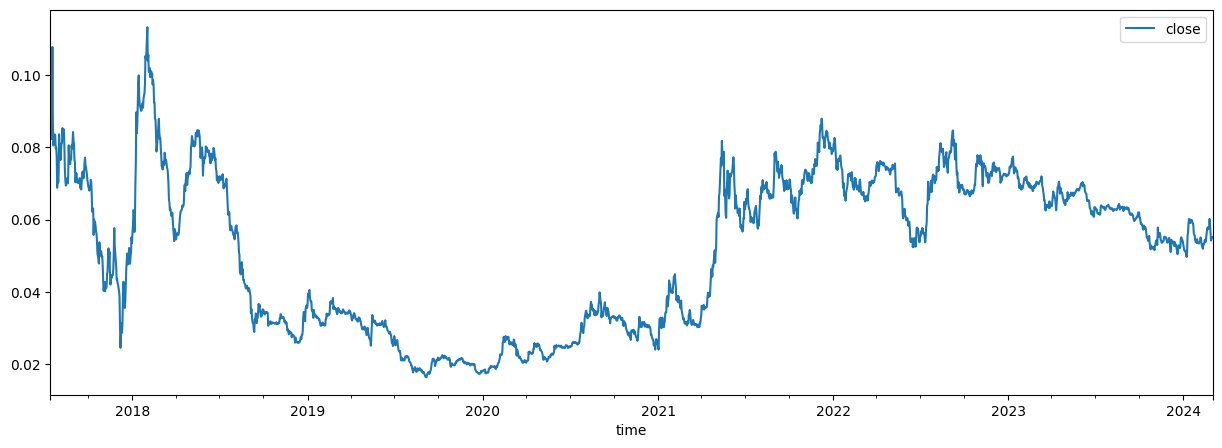

In [4]:
df.plot(figsize=(15,5))

In [5]:
TEST_SIZE = int(len(df)*0.30)
train, test = df.iloc[:-TEST_SIZE], df.iloc[-TEST_SIZE:]
x_train, x_test = np.array(range(train.shape[0])), np.array(range(train.shape[0], df.shape[0]))
train.shape, x_train.shape, test.shape, x_test.shape

((1698, 1), (1698,), (727, 1), (727,))

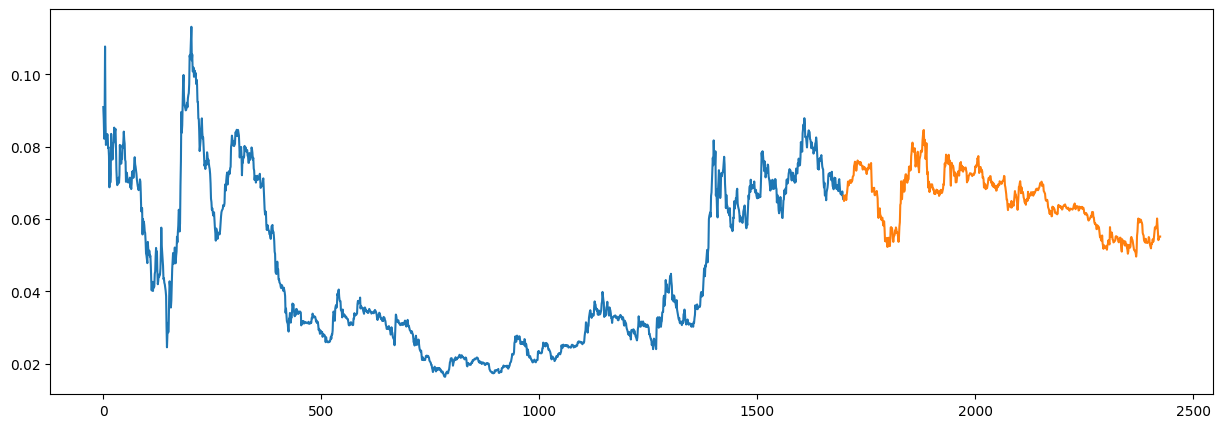

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(x_train, train)
ax.plot(x_test, test)

In [7]:
from pmdarima.arima import auto_arima

In [8]:
model = auto_arima(train, start_p=1, start_q=1,
                      test='adf',
                      max_p=5, max_q=5,
                      m=1,             
                      d=1,          
                      seasonal=False,   
                      start_P=0, 
                      D=None, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-16474.946, Time=7.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-16478.953, Time=0.87 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-16476.981, Time=1.63 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-16476.977, Time=3.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-16480.845, Time=0.16 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 13.004 seconds


In [9]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1698
Model:               SARIMAX(0, 1, 0)   Log Likelihood                8241.423
Date:                Sun, 14 Jul 2024   AIC                         -16480.845
Time:                        13:41:43   BIC                         -16475.409
Sample:                    07-14-2017   HQIC                        -16478.833
                         - 03-07-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       3.54e-06   3.48e-08    101.794      0.000    3.47e-06    3.61e-06
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):             35535.07
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               0.42   Skew:                             0.27
Prob(H) (two-sided):                  0.00   Kurtosis:                        25.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [10]:
prediction, confint = model.predict(n_periods=TEST_SIZE, return_conf_int=True)

prediction

2022-03-08    0.065575
2022-03-09    0.065575
2022-03-10    0.065575
2022-03-11    0.065575
2022-03-12    0.065575
                ...   
2024-02-28    0.065575
2024-02-29    0.065575
2024-03-01    0.065575
2024-03-02    0.065575
2024-03-03    0.065575
Freq: D, Length: 727, dtype: float64

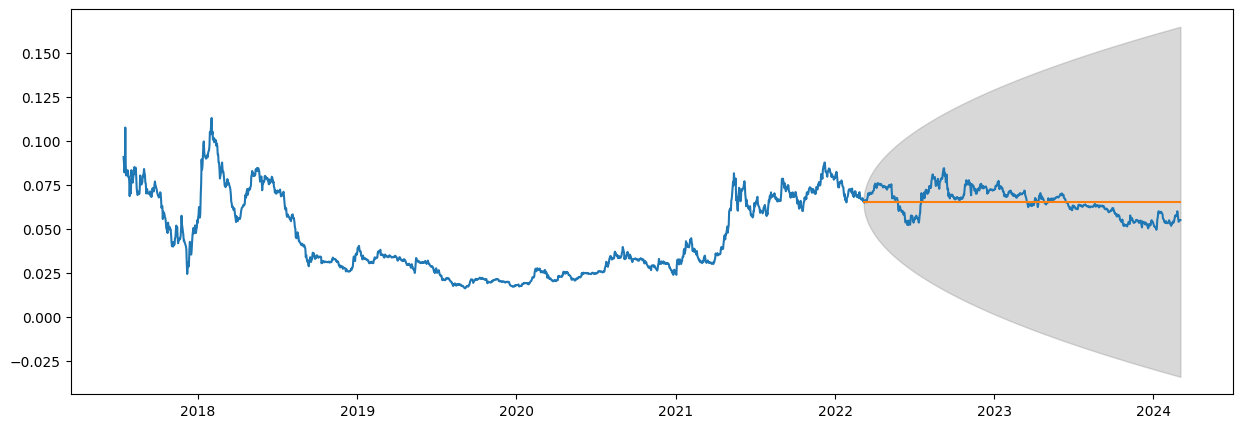

In [11]:
cf= pd.DataFrame(confint)
prediction_series = pd.Series(prediction,index=test.index)
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(df.close)
ax.plot(prediction_series)
ax.fill_between(prediction_series.index,
                cf[0],
                cf[1],color='grey',alpha=.3)

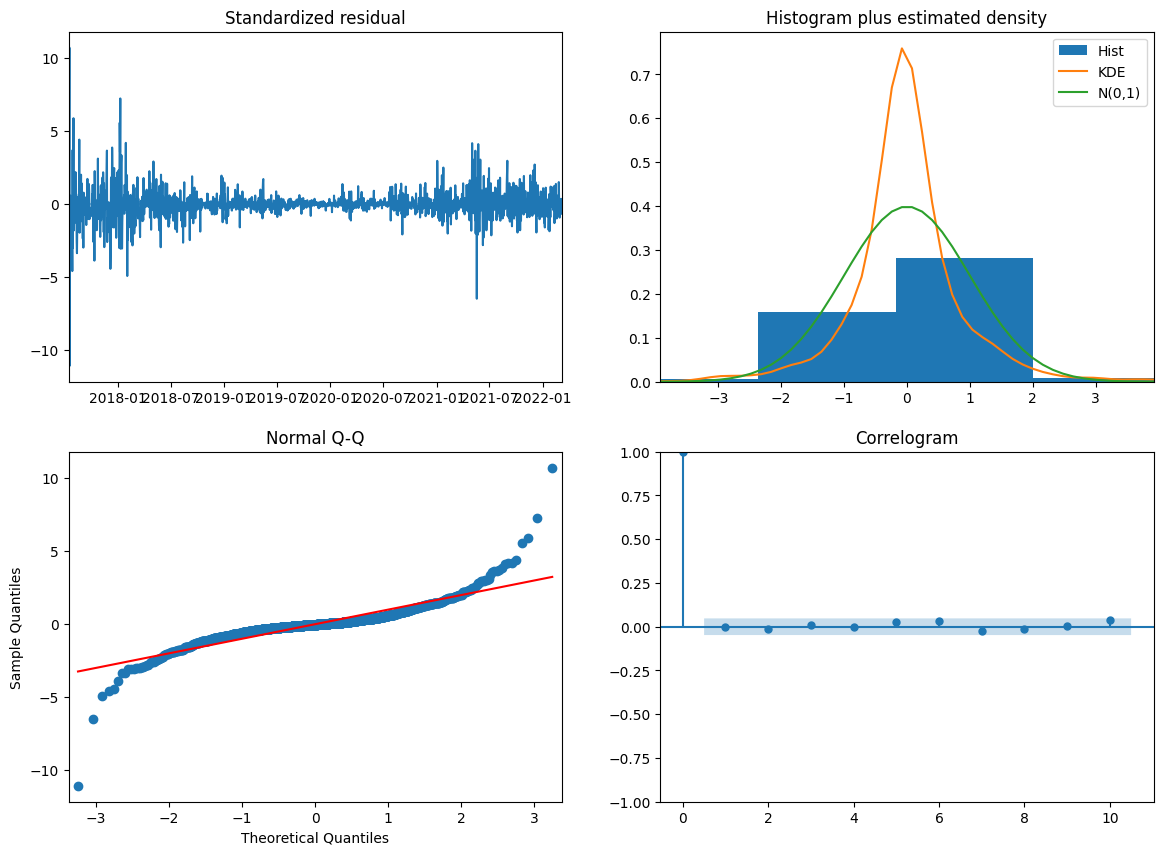

In [12]:
model.plot_diagnostics(figsize=(14,10))
plt.show()